### PACE Rapid Response Notebook

To Do:
- adapt hackweek code to pull pace data for a given product, lat/lon extent, and time range defined before and after an event of interest
- spatially bin l2 data consistently?
- Make a mask of only pixels present both datasets (to prevent bias), compare data w/ pretty maps

In [2]:
import cartopy.crs as ccrs
import earthaccess
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from matplotlib.colors import LogNorm
import cmocean
from dask.distributed import Client
from matplotlib.patches import Rectangle

### Development test-case
Hurricane Erin, look at chl-a before and after hurricane for MAB
Timeline (using worldview): 
- Hurricane off florida/gulf stream PACE imagery on AUG 20
- AUG 21, hurricane passed and clear imagery
- Aug 18/19 hurricane not there yet

Lat/Lon bounds: 
UL:32.09, -76.63 
LR:27.78, -77.80


### Workflow
- use a datapoint in the center of AOI and time bounds/ earthaccess search to determine a granule form which we will define our L3M-like grid (see dask_gridding tutorial notebook)
- define crs, tramsform, shape from this L3M-like granule (chla_L3M_aoi in dask_griddding.ipynb notebook from hackweek)
- do another earthdata search, for full AOI over time period (1 week ish pre hurricane)
- open all and calculate average of parameter (in this case chl-a) using dask (follow dask_griddding.ipynb section 4)
- repeat above with timespan post hurricane, using same crs, tramsform, shape for gridding
- at this point, have pre and post hurricane chl averages on same spatial grid. now, mask each for pixels that have date pre and post hurricane
- make graphic showing before/after. Calculate average pre and post (using mask to avoid bias) and calculate a % increase in chl-a


In [3]:
min_lon = -70
min_lat = 27.8
max_lon = -80
max_lat = 32.1

In [5]:
# user bounds
tspan = ("2025-08-21", "2025-08-24")# post hurricane time period
bbox = (min_lon, min_lat, max_lon, max_lat)

# math
avg_lon = (min_lon + max_lon)/2; avg_lat = (min_lat + max_lat)/2
bbox_pt = (avg_lon, avg_lat, avg_lon, avg_lat)# single point at center of defined bounds

In [6]:
results = earthaccess.search_data(
    short_name="PACE_OCI_L2_BGC_NRT",
    temporal=tspan,
    bounding_box=bbox_pt,# logic to select central point of bounding box
)
len(results)

2

In [7]:
paths = earthaccess.download(results, local_path="local_data/")

QUEUEING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/2 [00:00<?, ?it/s]

In [8]:
#paths = earthaccess.open(results)
paths

['local_data\\PACE_OCI.20250821T170142.L2.OC_BGC.V3_1.NRT.nc',
 'local_data\\PACE_OCI.20250824T170836.L2.OC_BGC.V3_1.NRT.nc']

In [9]:
# this cell takes up to 2 min to run, opens dataset w/ datatree, put all variables together, and fully load dataset to memory to make map plotting faster
datatree = xr.open_datatree(paths[0])
dataset = xr.merge(datatree.to_dict().values())
dataset = dataset.set_coords(("longitude", "latitude"))
dataset = dataset.load()

C:\Users\gtrolley\AppData\Local\Temp\ipykernel_25212\119976617.py:2: FutureWarning: In a future version, xarray will not decode the variable 'day' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  datatree = xr.open_datatree(paths[0])
C:\Users\gtrolley\AppData\Local\Temp\ipykernel_25212\119976617.py:2: FutureWarning: In a future version, xarray will not decode the variable 'msec' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarr

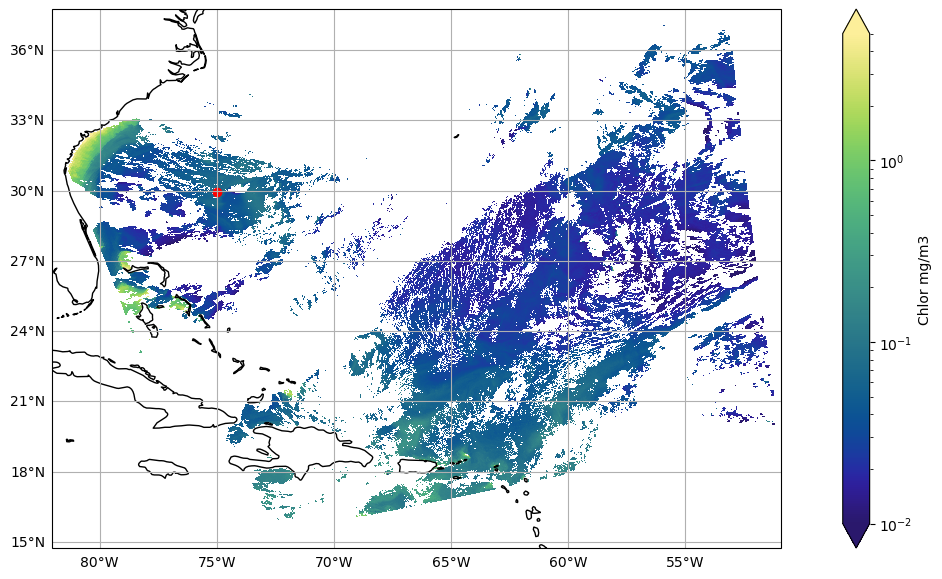

In [10]:
fig = plt.figure(figsize=(16,7))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels={"left": "y", "bottom": "x"})
plot = dataset['chlor_a'].plot(x="longitude", y="latitude", cbar_kwargs={'label': 'Chlor mg/m3'}, cmap=cmocean.cm.haline,norm=LogNorm(vmin=.01, vmax=5),  ax=ax)
ax.scatter([avg_lon],[avg_lat], c='r' )
                                       

(-70, 27.8, -80, 32.1)


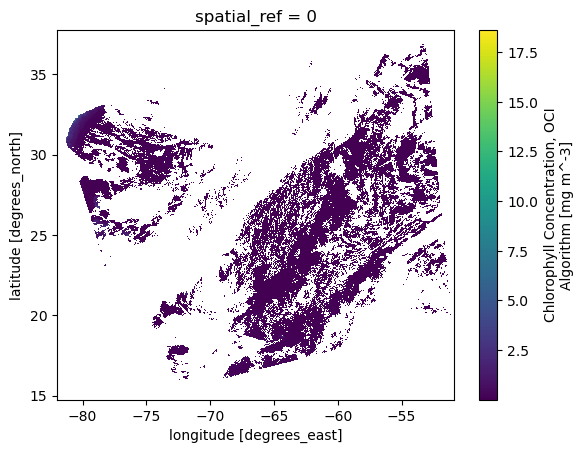

In [ ]:
chla = dataset["chlor_a"]# use code from dask_gridding notebook to transform L2 granule to L3M-like grid
chla = chla.rio.set_spatial_dims("pixels_per_line", "number_of_lines")
chla = chla.rio.write_crs("epsg:4326")
chla_L3M = chla.rio.reproject(
    dst_crs="epsg:4326",
    src_geoloc_array=(
        chla.coords["longitude"],
        chla.coords["latitude"],
    ),
)
chla_L3M = chla_L3M.rename({"x":"longitude", "y":"latitude"})
chla_L3M.plot()
print(bbox)


(20.8, 39.1)

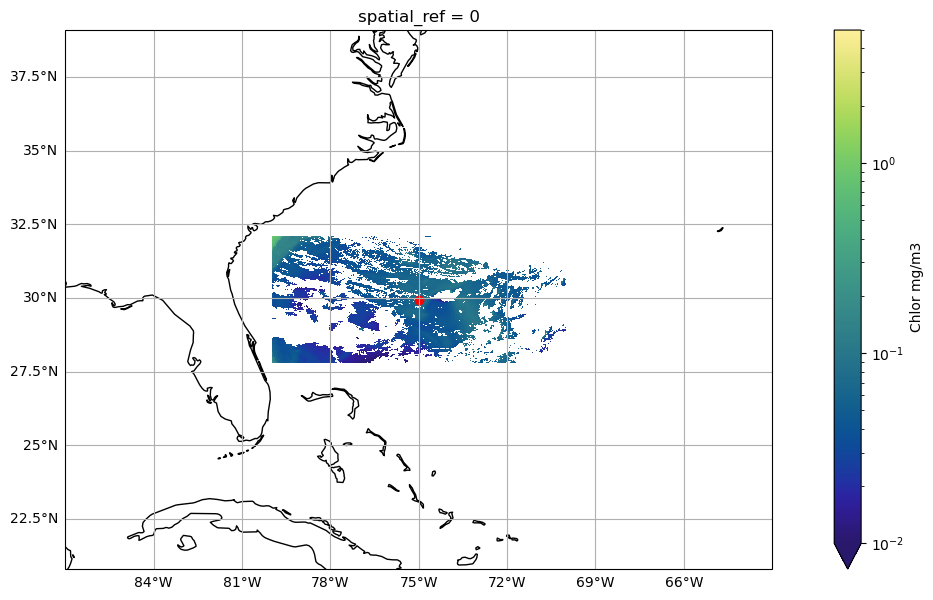

In [ ]:
chla_L3M_aoi = chla_L3M.sel(
    {
        "longitude": slice(bbox[2], bbox[0]),
        "latitude": slice(bbox[3], bbox[1]),
    },
)
# slice post hurricane to lat/lon bounds of interest

fig = plt.figure(figsize=(16,7))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels={"left": "y", "bottom": "x"})
plot = chla_L3M_aoi.plot(x="longitude", y="latitude", cbar_kwargs={'label': 'Chlor mg/m3'}, cmap=cmocean.cm.haline,norm=LogNorm(vmin=.01, vmax=5),  ax=ax)
ax.scatter([avg_lon],[avg_lat], c='r' )
ax.set_xlim(bbox[2]-7,bbox[0]+7,)
ax.set_ylim(bbox[1]-7,bbox[3]+7)

In [ ]:
# now, attempt to open multiple files using the dask approach from hackweek tutorial
# the one we already opened is the "after hurricane" data
# here, try to get 2 clear granules from 18th and 19th, open and L3M grid according to previous one

# user bounds
tspan = ("2025-08-18", "2025-08-20")
bbox = (min_lon, min_lat, max_lon, max_lat)

# math
avg_lon = (min_lon + max_lon)/2; avg_lat = (min_lat + max_lat)/2
bbox_pt = (avg_lon, avg_lat, avg_lon, avg_lat)# single point at center of defined bounds

results = earthaccess.search_data(
    short_name="PACE_OCI_L2_BGC_NRT",
    temporal=tspan,
    bounding_box=bbox_pt,# logic to select central point of bounding box
)
print(bbox_pt)
len(results)
paths = earthaccess.open(results)
print(paths)

(-75.0, 29.950000000000003, -75.0, 29.950000000000003)


QUEUEING TASKS | :   0%|          | 0/4 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/4 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/4 [00:00<?, ?it/s]

[<File-like object HTTPFileSystem, https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20250818T165447.L2.OC_BGC.V3_1.NRT.nc>, <File-like object HTTPFileSystem, https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20250818T183308.L2.OC_BGC.V3_1.NRT.nc>, <File-like object HTTPFileSystem, https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20250819T172952.L2.OC_BGC.V3_1.NRT.nc>, <File-like object HTTPFileSystem, https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20250820T180458.L2.OC_BGC.V3_1.NRT.nc>]


In [ ]:
#define functions
def grid_match(path, dst_crs, dst_shape, dst_transform):
    """Reproject a Level-2 granule to match a Level-3M-ish granule."""
    dt = xr.open_datatree(path)
    da = dt["geophysical_data"]["chlor_a"]
    da = da.rio.set_spatial_dims("pixels_per_line", "number_of_lines")
    da = da.rio.set_crs("epsg:4326")
    da = da.rio.reproject(
        dst_crs,
        shape=dst_shape,
        transform=dst_transform,
        src_geoloc_array=(
            dt["navigation_data"]["longitude"],
            dt["navigation_data"]["latitude"],
        ),
    )
    da = da.rename({"x":"longitude", "y":"latitude"})
    return da

def time_from_attr(ds):
    """Set the start time attribute as a dataset variable.
 
    Parameters
    ----------
    ds
        a dataset corresponding to a Level-2 granule
    """
    datetime = ds.attrs["time_coverage_start"].replace("Z", "")
    ds["time"] = ((), np.datetime64(datetime, "ns"))
    ds = ds.set_coords("time")
    return ds

In [30]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 32,Total memory: 31.69 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:62985,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:63024,Total threads: 4
Dashboard: http://127.0.0.1:63029/status,Memory: 3.96 GiB
Nanny: tcp://127.0.0.1:62988,


In [ ]:
crs = chla_L3M_aoi.rio.crs# set mapping parameters from file transformed earlier
shape = chla_L3M_aoi.rio.shape
transform = chla_L3M_aoi.rio.transform()

In [41]:
futures = client.map(
    grid_match,
    paths,
    dst_crs=crs,
    dst_shape=shape,
    dst_transform=transform,
)
futures

[<Future: pending, key: grid_match-3de151d7af7ce17b67ca4b0214a6a8b3>,
 <Future: pending, key: grid_match-823a6be8bfc2a048f08cb0792410d613>,
 <Future: pending, key: grid_match-de173d06bfed9f0343d82dc52d2aa885>,
 <Future: pending, key: grid_match-6a7965a0ee60f38b0c947b8c14e70e39>]

In [42]:
kwargs = {"combine": "nested", "concat_dim": "time"}
attrs = xr.open_mfdataset(paths, preprocess=time_from_attr, **kwargs)
attrs

<xarray.Dataset> Size: 32B
Dimensions:  (time: 4)
Coordinates:
  * time     (time) datetime64[ns] 32B 2025-08-18T16:54:47.187000 ... 2025-08...
Data variables:
    *empty*
Attributes: (12/47)
    title:                             OCI Level-2 Data BGC
    product_name:                      PACE_OCI.20250818T165447.L2.OC_BGC.V3_...
    processing_version:                3.1
    history:                           l2gen par=/data6/sdpsoper/vdc/vpu25/wo...
    instrument:                        OCI
    platform:                          PACE
    ...                                ...
    geospatial_lon_min:                -80.60451
    startDirection:                    Ascending
    endDirection:                      Ascending
    day_night_flag:                    Day
    earth_sun_distance_correction:     0.9761009812355042
    geospatial_bounds:                 POLYGON ((15.47274 -48.46203, 10.46936...

In [ ]:
chla = xr.combine_nested(client.gather(futures), concat_dim="time")# open all 4 files. they are stored in same xarray dataset at different "time" coordinates 
chla["time"] = attrs["time"]
chla

<xarray.DataArray 'chlor_a' (time: 4, latitude: 283, longitude: 658)> Size: 3MB
array([[[0.29334715, 0.24644469, 0.24644469, ...,        nan,
                nan,        nan],
        [0.27190182, 0.27190182, 0.23341738, ...,        nan,
                nan,        nan],
        [0.23898028, 0.23898028, 0.22866783, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ..., 0.02330984,
         0.0231251 , 0.0226135 ],
        [       nan,        nan,        nan, ..., 0.0221587 ,
         0.02131344, 0.02531137],
        [       nan,        nan,        nan, ...,        nan,
         0.02111193, 0.02111193]],

       [[0.32452255, 0.3007961 , 0.3007961 , ...,        nan,
                nan,        nan],
        [0.29552165, 0.2699507 , 0.2699507 , ...,        nan,
                nan,        nan],
        [0.27477247, 0.27477247, 0.26871723, ...,        nan,
                nan,        nan],
...
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [0.18497969, 0.15279171, 0.09504995, ...,        nan,
                nan,        nan],
        [0.17562467, 0.13684008, 0.10062832, ...,        nan,
                nan,        nan],
        [0.16227333, 0.13441679, 0.10365435, ...,        nan,
                nan,        nan]]], shape=(4, 283, 658), dtype=float32)
Coordinates:
  * longitude    (longitude) float64 5kB -79.99 -79.97 -79.96 ... -70.03 -70.01
  * latitude     (latitude) float64 2kB 32.09 32.08 32.06 ... 27.84 27.83 27.81
    spatial_ref  int64 8B 0
  * time         (time) datetime64[ns] 32B 2025-08-18T16:54:47.187000 ... 202...

(20.8, 39.1)

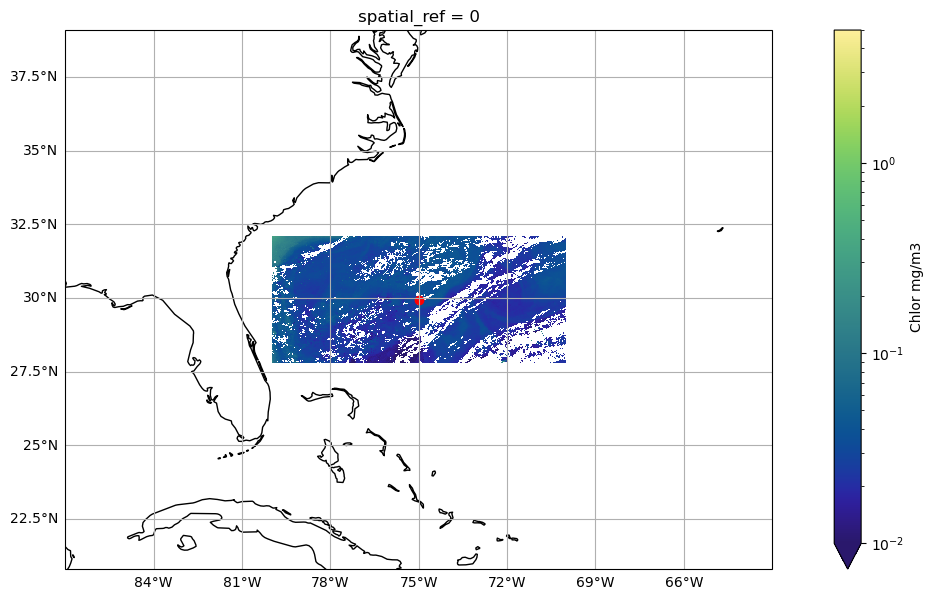

In [ ]:
# plot the average of the files we just opened (4 in case of this example)

fig = plt.figure(figsize=(16,7))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels={"left": "y", "bottom": "x"})
plot = chla.mean("time").plot(x="longitude", y="latitude", cbar_kwargs={'label': 'Chlor mg/m3'}, cmap=cmocean.cm.haline,norm=LogNorm(vmin=.01, vmax=5),  ax=ax, robust=True)
ax.scatter([avg_lon],[avg_lat], c='r' )
ax.set_xlim(bbox[2]-7,bbox[0]+7,)
ax.set_ylim(bbox[1]-7,bbox[3]+7)

In [ ]:
client.close()

In [ ]:
## at this point, have 1 granule representing "post-hurricane", and a  nice 2 day avg of pre hurricane.
# want to compare the 2
# before: chla_L3M_aoi
# after chla
post_mean = chla.mean("time")

post_mean['longitude'] = post_mean['longitude'].round(5)# round lat/lon to 5 decimals, was having issues with floats at large # of decimals not being exactly the same
post_mean['latitude'] = post_mean['latitude'].round(5)
chla_L3M_aoi['longitude'] = chla_L3M_aoi['longitude'].round(5)
chla_L3M_aoi['latitude'] = chla_L3M_aoi['latitude'].round(5)

pre_mean = chla_L3M_aoi# rename for simplicity


# Create a mask where both datasets have valid values
mask = ~np.isnan(post_mean) & ~np.isnan(pre_mean)

# Apply mask to both datasets
post_mean = post_mean.where(mask)
pre_mean = pre_mean.where(mask)


Text(0.5, 1.0, 'post_hurricane 8/21')

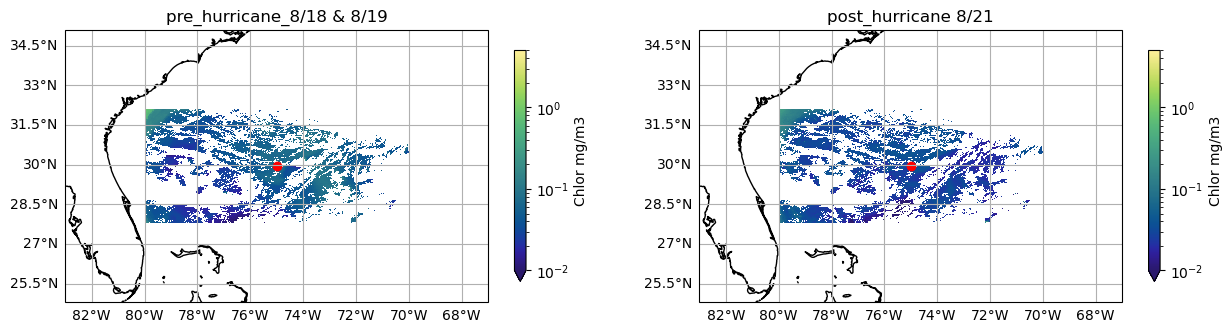

In [93]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6), subplot_kw={'projection': ccrs.PlateCarree()})
ax[0].gridlines(draw_labels={"left": "y", "bottom": "x"})
plot = pre_mean.plot(x="longitude", y="latitude", cbar_kwargs={'label': 'Chlor mg/m3', 'shrink':0.5}, cmap=cmocean.cm.haline,norm=LogNorm(vmin=.01, vmax=5),  ax=ax[0], robust=True)
ax[0].scatter([avg_lon],[avg_lat], c='r' )
ax[0].set_xlim(bbox[2]-3,bbox[0]+3,)
ax[0].set_ylim(bbox[1]-3,bbox[3]+3)
ax[0].coastlines()
ax[0].set_title('pre_hurricane_8/18 & 8/19')


ax[1].gridlines(draw_labels={"left": "y", "bottom": "x"})
plot = post_mean.plot(x="longitude", y="latitude", cbar_kwargs={'label': 'Chlor mg/m3', 'shrink':0.5}, cmap=cmocean.cm.haline,norm=LogNorm(vmin=.01, vmax=5),  ax=ax[1], robust=True)
ax[1].scatter([avg_lon],[avg_lat], c='r' )
ax[1].set_xlim(bbox[2]-3,bbox[0]+3,)
ax[1].set_ylim(bbox[1]-3,bbox[3]+3)
ax[1].coastlines()
ax[1].set_title('post_hurricane 8/21')


# ax.coastlines()
# ax.gridlines(draw_labels={"left": "y", "bottom": "x"})
# plot = chla.mean("time").plot(x="longitude", y="latitude", cbar_kwargs={'label': 'Chlor mg/m3'}, cmap=cmocean.cm.haline,norm=LogNorm(vmin=.01, vmax=5),  ax=ax, robust=True)
# ax.scatter([avg_lon],[avg_lat], c='r' )
# ax.set_xlim(bbox[2]-7,bbox[0]+7,)
# ax.set_ylim(bbox[1]-7,bbox[3]+7)

Text(0.5, 1.0, 'post_hurricane chla higher')

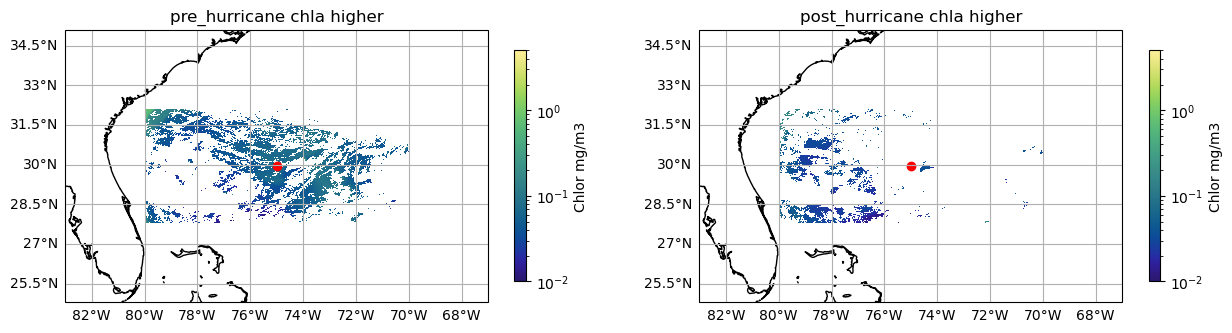

In [ ]:
# new mask to show where post > pre
mask2 = post_mean>pre_mean
mask3 = post_mean<pre_mean

# Apply mask to both datasets
post_mean_masked = post_mean.where(mask2)# locations where chla is higher post hurricane
pre_mean_masked = pre_mean.where(mask3)# locations where chla is higher pre hurricane


fig, ax = plt.subplots(1, 2, figsize=(15, 6), subplot_kw={'projection': ccrs.PlateCarree()})
ax[0].gridlines(draw_labels={"left": "y", "bottom": "x"})
plot = pre_mean_masked.plot(x="longitude", y="latitude", cbar_kwargs={'label': 'Chlor mg/m3', 'shrink':0.5}, cmap=cmocean.cm.haline,norm=LogNorm(vmin=.01, vmax=5),  ax=ax[0], robust=True)
ax[0].scatter([avg_lon],[avg_lat], c='r' )
ax[0].set_xlim(bbox[2]-3,bbox[0]+3,)
ax[0].set_ylim(bbox[1]-3,bbox[3]+3)
ax[0].coastlines()
ax[0].set_title('pre_hurricane chla higher')


ax[1].gridlines(draw_labels={"left": "y", "bottom": "x"})
plot = post_mean_masked.plot(x="longitude", y="latitude", cbar_kwargs={'label': 'Chlor mg/m3', 'shrink':0.5}, cmap=cmocean.cm.haline,norm=LogNorm(vmin=.01, vmax=5),  ax=ax[1], robust=True)
ax[1].scatter([avg_lon],[avg_lat], c='r' )
ax[1].set_xlim(bbox[2]-3,bbox[0]+3,)
ax[1].set_ylim(bbox[1]-3,bbox[3]+3)
ax[1].coastlines()
ax[1].set_title('post_hurricane chla higher')
